# WFP Transport Model

This notebook explores the input data and model construction for the WFP Transport Model. We start by exploring the input parameter data, looking for simple relationships, colinearity, and grouping. We then develop models and evaluate these models.

In [29]:
%matplotlib inline
import pandas
import copy
import numpy as np
import sklearn as skl
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn import cross_validation
from pandas import DataFrame
from collections import defaultdict

fname = "/home/ebaumer/Data/kimetrica/wfp/wfp_reduced_2.csv"

def splt_line(line):
    ''' Function to read in the data
    '''
    rtn_dict = {}
    vals = line.strip().split(',')
    
    rtn_dict["origin_cty"] = vals[0].strip().lower()
    rtn_dict["destination_cty"] = vals[1].strip().lower()
    rtn_dict["diesel_price"] = float(vals[2].strip().lower())
    rtn_dict["origin_cty_code"] = int(vals[3].strip())
    rtn_dict["destination_cty_code"] = int(vals[4].strip())
    rtn_dict["origin_cntry_code"] = int(vals[5].strip())
    rtn_dict["destination_cntry_code"] = int(vals[6].strip())
    rtn_dict["cross_brd_flg"] = int(vals[7].strip())
    rtn_dict["total_load"] = float(vals[8].strip())
    rtn_dict["num_trucks"] = int(vals[9].strip())
    rtn_dict["tariff_usd_kg_km"] = float(vals[10].strip())
    rtn_dict["tariff_usd_kg"] = float(vals[11].strip())
    rtn_dict["tariff_usd_km"] = float(vals[12].strip())
    rtn_dict["distance"] = float(vals[13].strip())
    rtn_dict["cbk_mean_rate"] = float(vals[14].strip())
    
    return rtn_dict

In [12]:
#--------------------
# Road Transport Data
#--------------------
road_dict = defaultdict(list)

with open(fname, 'r') as fid:
    for line in fid.readlines():
        tmp = splt_line(line)
        for k,v in tmp.iteritems():
            road_dict[k].append(v)

pdata = DataFrame.from_dict(road_dict)
pdata = DataFrame.drop_duplicates(pdata)


# Exploratory Input Analysis

Before any modeling takes place we begin taking a look at the input parameters. We do this to look at preliminary relationships between the input parameter data and the target function. This will give us an idea regarding the linearity of the relationship or any possible groupings of data.

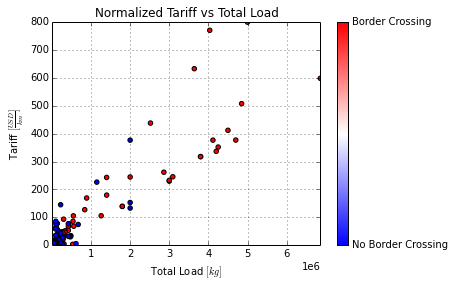

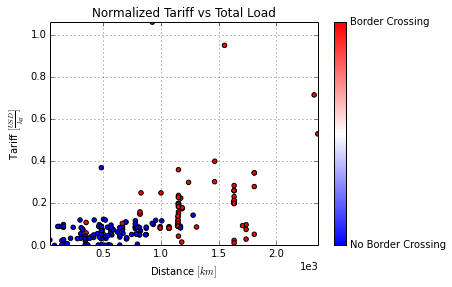

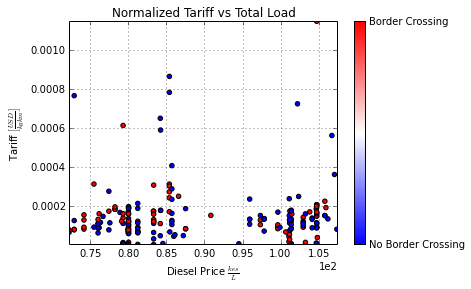

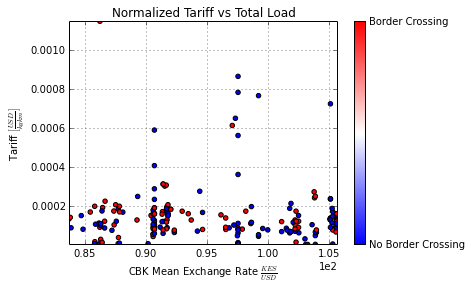

In [25]:
#-------------------------------------------
# Plot Normalized Tariff vs Input Parameters
#-------------------------------------------
ylist = ["tariff_usd_km", "tariff_usd_kg", "tariff_usd_kg_km", "tariff_usd_kg_km"]
xlist = ["total_load", "distance", "diesel_price", "cbk_mean_rate"]
ylabel = [r"Tariff $[\frac{USD}{km}]$", r"Tariff $[\frac{USD}{kg}]$", 
          r"Tariff $[\frac{USD}{kg km}]$", r"Tariff $[\frac{USD}{kg km}]$"]
xlabel = [r"Total Load $[kg]$", r"Distance $[km]$", r"Diesel Price $\frac{kes}{L}$",
          r"CBK Mean Exchange Rate $\frac{KES}{USD}$"]

for i,x,y in zip(range(0,len(xlist)),xlist, ylist):

    red_data = pdata[[y, x, "cross_brd_flg"]].values
    cm = plt.cm.get_cmap("bwr")
    fig, ax = plt.subplots()
    sc = ax.scatter(red_data[:,1], red_data[:,0], c=red_data[:,2], cmap=cm)
    ax.set_ylabel(ylabel[i])
    ax.set_xlabel(xlabel[i])
    ax.grid(True)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
    ax.set_xlim([np.min(red_data[:,1]),np.max(red_data[:,1])])
    ax.set_ylim([np.min(red_data[:,0]),np.max(red_data[:,0])])
    ax.set_title("Normalized Tariff vs Total Load")
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    cbar = fig.colorbar(sc, ticks=[0,1])
    cbar.ax.set_yticklabels(["No Border Crossing", "Border Crossing"])
    plt.show()


The key input parameters are believed to be distance and load. When the tariff is compared against one it is normalized by the other. For example, if the tariff is compared to distance then it is normalized by load. This is an attempt to isolate the relationships.

A strong relationship can be seen between the normalized tariff and the total cargo load. This may be partially due to an artifical construct. In that the total tariff is derived from the equation:

$$tariff_{total} \left[USD\right] = tariff \left[\frac{USD}{kg}\right] * load_{total} \left[kg\right]$$

There does not seem to be a direct correlation between the diesel prices and tariff or the CBK mean exchange rate and tariff. **This may be due to the high temporal variability of diesel prices and mean exchange rate values and the inability to accuratley determine the date of each transaction**

We will continue to explore the strength of input parameters to the criterion variable (tariff) through the size of the coefficients of the various input parameters for each model.

There also seems to be a distinct grouping between data which are intra-country and data which are inter-country.  

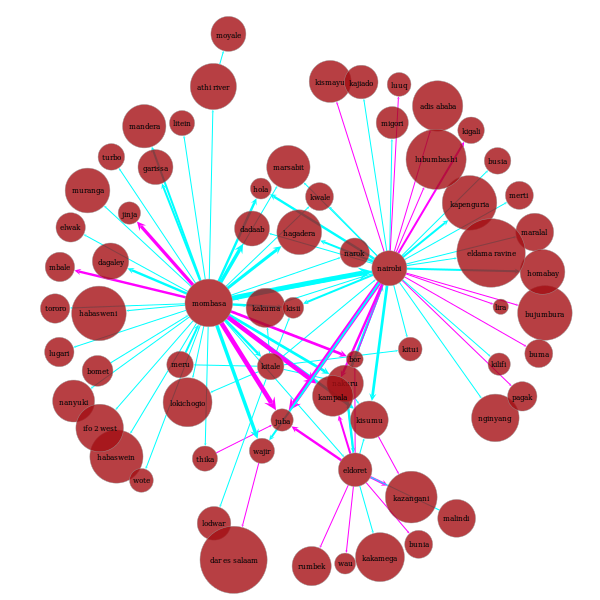

In [122]:
from collections import defaultdict, Counter, OrderedDict
import copy
import csv
import graph_tool.all as gt
import itertools
import logging
import matplotlib
import numpy as np
import operator
import os
import random
import sys

class TransportTreeBase(object):
    ''' This Class creates a graph from the verticies and edges specified in 
        a data file with specific format. Methods allow for the isolation of 
        the local network for a specific vertex and determining page rank
    '''
    
    def __init__(self):        
        self.vert_fltr = None
        self.edge_fltr = None
        self.density = None
        self.max_degree = None
        self.n_deg_inds = None
        self.g = None
        self.pgrank_global = None
        self.pos = None
        
        self.logger = logging.getLogger("GraphTree")
        self.logger.setLevel(logging.DEBUG)   
        hdlr1 = logging.StreamHandler(stream=sys.stdout)
        fmt1 = logging.Formatter("%(asctime)s [%(threadName)-12.12s] [%(levelname)-5.5s]  %(message)s")
        hdlr1.setFormatter(fmt1)
        self.logger.addHandler(hdlr1)  
            
    
    def read_file_wfp(self, fname):
        ''' Constructs the verticies and edges of the graph and a 
            dictionary which maps the unique user id to the vertex index
        '''
        verts = set([])
        g = gt.Graph()
        
        with open(fname, 'r') as fid:
            #------------------------------------------
            # Loop through to find all unique verticies
            #------------------------------------------   
            origins = []
            dests = []
            borderFlg = []
            
            for line in fid.readlines():
                loc1 = line.strip().split(",")[0].lower()
                loc2 = line.strip().split(",")[1].lower()
                brdFlg = int(line.strip().split(",")[2])
                verts.add(loc1)
                verts.add(loc2)
                origins.append(loc1)
                dests.append(loc2)
                borderFlg.append(brdFlg)
            
        verts = list(verts)
        n_verts = len(verts)
        self.vlist = g.add_vertex(n_verts)
        
        #-----------------------------
        # Maps location name to vertex
        #-----------------------------
        self.vert_loc_map = g.new_vertex_property('string', vals=verts)
        loc_ids = {uid:i for (i,uid) in enumerate(verts)}
        
        #--------------------------------------
        # Create unique edges between verticies
        #--------------------------------------
        edge_set = set()
        edge_id = {}
        edge_cnts = []
        brder = []
        k = 0
        
        for i,j,l in zip(origins, dests, borderFlg):
            temp = (loc_ids[i], loc_ids[j])
            if not (temp in edge_set):
                edge_set.add(temp)
                g.add_edge(temp[0], temp[1])                    
                edge_id[":".join((str(i),str(j)))] = k
                k += 1                    
                brder.append(l)
                
            edge_cnts.append(edge_id[":".join((str(i),str(j)))])
        
        edge_counter = Counter(edge_cnts)
        
        #---------------------------------
        # Edge property: Number of times a 
        # route appears in data set
        #---------------------------------
        sorted_edge_counter = OrderedDict(sorted(edge_counter.items()))
        temp = [sorted_edge_counter[k] for k in sorted_edge_counter]
        self.edge_size_prop = g.new_edge_property('int', vals=temp)
        
        #-------------------------------
        # Edge property: Border Crossing
        #-------------------------------
        self.edge_color_prop = g.new_edge_property('int', vals=brder)
            

        #self.pos = gt.sfdp_layout(g)
        self.pos = gt.arf_layout(g, max_iter=0)
        #self.pos = gt.radial_tree_layout(g, g.vertex(loc_ids["mombasa"]))
        self.g = g

    def draw_transport_graph(self, giraffe):
        
        vprops = {"font_size":7, "pen_width":0.5, "size":1, 
                  "text_color":'k'}
        gt.graph_draw(giraffe,
                      pos=self.pos,
                      vertex_text=self.vert_loc_map,
                      vprops=vprops,
                      ecmap=matplotlib.cm.get_cmap("cool"),
                      edge_color=self.edge_color_prop,
                      edge_pen_width=gt.prop_to_size(self.edge_size_prop,
                                                     mi=1,
                                                     ma=5),
                      inline=True)

#-------------------------------------------
# Base directory for reading in the data and 
# drawing the graph output
#-------------------------------------------
basedir = '/home/ebaumer/Data/kimetrica/wfp/'

#---------------------------------------------------------------------
# File with example stylekick data. Right now we are ignoring the
# feed type and just using the user ID to create nodes and connections
#---------------------------------------------------------------------
fname = os.path.join(basedir, 'wfp_OD_network.csv')

#------------------------------------------------------------------------
# Instantiate Class for creating network graph. The Class is not specific
# for an individual user. The class is specific for the social network. 
#------------------------------------------------------------------------
test = TransportTreeBase()

#-------------------------------
# Read in test data from example 
#-------------------------------
test.read_file_wfp(fname)

#-------------
# Print graphs
#-------------
test.draw_transport_graph(test.g)


# Model Development

## Linear Regression

We begin with a Lasso linear regression model. The Lasso model consists of a linear model trained with a $l_{1}$ prior regularization. The objective function is given as:

$$\min_{w}\frac{1}{2n_{samples}}\left|\left|Xw-y\right|\right|^{2}_{2} + \alpha\left|\left|w\right|\right|_{1}$$


The cost function is a minimization of the least-squares with a penalty of $\alpha\left|\left|w\right|\right|_{1}$, where $\alpha$ is a parameter and $\left|\left|w\right|\right|_{1}$ is the $l_{1}$ norm of the parameter vector.

To calculate the performance of the model we split the data into a training and testing set using a k-fold method with 5 folds. Kfold divides all the samples in $k$ groups of samples, called folds of equal size if possible. The model is trained with $k-1$ folds and the fold that is left out is used for testing the model. This is repeated until all folds are tested.

Before training and testing the models we normalize all the data using the standard score or z-scores.



****************************************************************************************
Coefficient of determination R^2 = 0.636 (+/- 0.272) 


Input Parameter           Coefficient              
______________________________________________________________________
Cross Border              0.0                      
Number of Trucks          6.553                    
Distance                  1.665                    
Diesel Price              -0.0                     
Total Load                7.399                    
CBK Mean Rate             0.0                      
****************************************************************************************


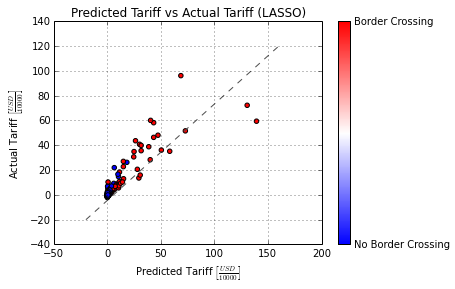

In [115]:
inpt_param_lst = ["Cross Border", "Number of Trucks", "Distance", 
                  "Diesel Price", "Total Load", "CBK Mean Rate"]

red_data = pdata[["cross_brd_flg", "num_trucks", "distance", 
                  "diesel_price", "total_load", "cbk_mean_rate",
                  "tariff_usd_kg"]].values

#-----------------------------------------------------------------
# Normalize parameter data. Save tranformers for later (if needed)
#-----------------------------------------------------------------
cross_brd_flg_scaler = StandardScaler()
cross_brd_flg_scaled = cross_brd_flg_scaler.fit_transform(red_data[:,0].reshape(-1,1))

num_trucks_scaler = StandardScaler()
num_trucks_scaled = num_trucks_scaler.fit_transform(red_data[:,1].reshape(-1,1))

#distance_scaler = StandardScaler()
#distance_scaled = distance_scaler.fit_transform(np.log(red_data[:,2]).reshape(-1,1))

distance_scaler = StandardScaler()
distance_scaled = distance_scaler.fit_transform(red_data[:,2].reshape(-1,1))

diesel_price_scaler = StandardScaler()
diesel_price_scaled = diesel_price_scaler.fit_transform(red_data[:,3].reshape(-1,1))

total_load_scaler = StandardScaler()
total_load_scaled = total_load_scaler.fit_transform(red_data[:,4].reshape(-1,1))

cbk_mean_rate_scaler = StandardScaler()
cbk_mean_rate_scaled = cbk_mean_rate_scaler.fit_transform(red_data[:,5].reshape(-1,1))

#-----------------------------------
# Create total tariff in units [USD]
# and create transformer
#-----------------------------------
tariff = red_data[:,6] * red_data[:,4] / 10000. 

#---------------------------------
# Construct input parameter matrix
#---------------------------------
parm_data = np.hstack((cross_brd_flg_scaled, num_trucks_scaled, distance_scaled,
                       diesel_price_scaled, total_load_scaled, cbk_mean_rate_scaled))

#-----------------
# Initialize Model
#-----------------
model = Lasso(alpha=1.0,
              fit_intercept=True,
              normalize=False,
              precompute=False,
              max_iter=1000,
              tol=1.0E-4,
              warm_start=False,
              positive=False
              )

#---------------------------------
# Create cross validation iterator
#---------------------------------
loo = cross_validation.LeaveOneOut(n=len(tariff))   # Leave One Out
kf = cross_validation.KFold(len(tariff), n_folds=5) # K-fold

#-------------------------------------------------------------
# Calculate cross validation score for training/testing data
# scoring method for lasso is coefficient of determination R^2
#-------------------------------------------------------------
score = cross_validation.cross_val_score(model, 
                                         parm_data, 
                                         tariff,  
                                         cv=kf, 
                                         n_jobs=2
                                        )

#------------------------------
# Fit the model to all the data
#------------------------------
model.fit(parm_data, tariff)

print "\n"
print "****************************************************************************************"
print "Coefficient of determination R^2 = {0:0.3} (+/- {1:0.3}) ".format(score.mean(), score.std()*2.)
print "\n"
print "{0:25s} {1:25s}".format("Input Parameter", "Coefficient")
print "______________________________________________________________________"
for i,coefficient in enumerate(model.coef_):
    print "{0:<25s} {1:<25.4}".format(inpt_param_lst[i],coefficient)

print "****************************************************************************************"
y_pred = model.predict(parm_data)

fig, ax = plt.subplots()
sc = ax.scatter(tariff, y_pred, c=red_data[:,0], cmap=cm)
ax.set_ylabel(r"Actual Tariff $\left[\frac{USD}{10000}\right]$")
ax.set_xlabel(r"Predicted Tariff $\left[\frac{USD}{10000}\right]$")
ax.grid(True)
# ax.set_xlim([np.min(red_data[:,1]),np.max(red_data[:,1])])
# ax.set_ylim([np.min(red_data[:,0]),np.max(red_data[:,0])])
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_title("Predicted Tariff vs Actual Tariff (LASSO)")
# plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
cbar = fig.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(["No Border Crossing", "Border Crossing"])
plt.show()


## Results
We are using the total tariff in USD and have scaled the values by dividing by 10000 when running the model. This is done for easy interprertation of the coefficients. 

1. The Lasso model helps in the selection of variables to use for a model. From the results one can justify creating a model with only number of trucks, distance, and total load.
2. The strongest variable is total load; however, this should be expected since the calculation of the total tariff was derived from the unit load.

The Lasso model is good for out-of-sample performance, thus should be used to predict future values. It is also useful in variable selection. 

The above plot shows the actual tariff vs predicted tariff. **It is important to note that the model fit was conducted on the same set of data used to train the model. This is clearly data snooping and the results shown in the graph are better than one could expect out of sample** We use this to illustrate a clear bias in the model.

x1 = Cross Border Flag
x2 = Number of Trucks
x3 = Distance
x4 = Diesel Price
x5 = Total Load
x6 = CBK Mean Rate


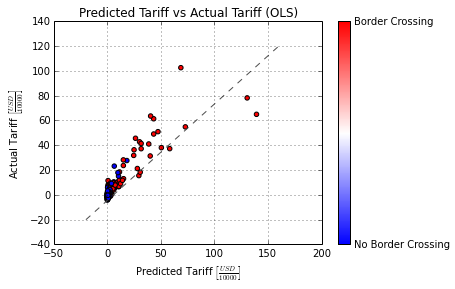

In [114]:
X = sm.add_constant(parm_data)
Y = tariff
model = sm.OLS(Y,X)
results = model.fit()
print "\n"
print "x1 = Cross Border Flag"
print "x2 = Number of Trucks"
print "x3 = Distance"
print "x4 = Diesel Price"
print "x5 = Total Load"
print "x6 = CBK Mean Rate"
results.summary()

#-------------------------
# Plot actual vs predicted
#-------------------------
y_pred = results.predict(X)
fig, ax = plt.subplots()
sc = ax.scatter(Y, y_pred, c=red_data[:,0], cmap=cm)
ax.set_ylabel(r"Actual Tariff $\left[\frac{USD}{10000}\right]$")
ax.set_xlabel(r"Predicted Tariff $\left[\frac{USD}{10000}\right]$")
ax.grid(True)
diag_line, = ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
ax.set_title("Predicted Tariff vs Actual Tariff (OLS)")
cbar = fig.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(["No Border Crossing", "Border Crossing"])
plt.show()

**Performing an OLS with all variables shows similar results regarding variable selection** P-values are significant for number of trucks, distance, and total load. Therefore, we can reject the null hypothesis for these parameters. The R-squared value is slightly better than Lasso because we retain the influence of all parameters. OLS will typically give a better in-sample performance than Lasso; however, we are interested in the out of sample performance.